# 교육 및 경제활동에 따른 금연 성공 상관관계 분석

**분석자**: 오흥재 (vfxpedia)  
**분석일자**: 2025-10-07  
**주제**: 교육수준, 경제활동이 금연 성공에 미치는 영향

---

## 📋 분석 목표

1. **교육 수준에 따른 흡연율 상관 관계** (오흥재 담당)
2. **경제활동에 따른 금연 성공 상관 관계** (오흥재 담당)

### 가설
- H1: 교육 수준이 높을수록 금연 성공률이 높다
- H2: 경제활동 안정성이 높을수록 금연 성공률이 높다
- H3: 직종별로 금연 성공률에 차이가 있다
- H4: 혼인 상태가 금연 성공에 영향을 미친다

## 1. 환경 설정 및 데이터 로드

In [1]:
# 라이브러리 임포트
import sys
sys.path.append('C:/SKN_19/SKN19-2nd-2Team')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 디코딩 유틸리티 임포트
from data.var_mapping import VAR_DICT, get_var_name, get_var_value
from util.decode_helper import (
    decode_dataframe, 
    filter_special_codes,
    get_label,
    print_var_info,
    get_summary_stats,
    prepare_plot_data
)

print("✅ 모든 라이브러리 로드 완료")

✅ 모든 라이브러리 로드 완료


In [2]:
# 데이터 로드
df = pd.read_csv('../../data/analy_data.csv')

print(f"데이터 shape: {df.shape}")
print(f"\n타겟 변수 (churn) 분포:")
print(df['churn'].value_counts())
print(f"\n금연 성공률: {df['churn'].mean() * 100:.2f}%")

데이터 shape: (89822, 210)

타겟 변수 (churn) 분포:
churn
1    49251
0    40571
Name: count, dtype: int64

금연 성공률: 54.83%


## 2. 분석 대상 변수 확인

In [3]:
# 분석할 변수 목록
analysis_vars = {
    'sob_01z1': '교육수준(최종학력)',
    'sob_02z1': '졸업상태',
    'soa_01z1': '경제활동 여부',
    'soa_06z2': '직업분류',
    'soa_07z1': '종사상 지위',
    'sod_02z3': '혼인상태'
}

print("📋 분석 대상 변수\n" + "="*50)
for var_code, var_name in analysis_vars.items():
    print(f"{var_code:<15} : {var_name}")
    print(f"  - 결측값: {df[var_code].isna().sum()}개 ({df[var_code].isna().mean()*100:.2f}%)")
    print(f"  - 유효값: {df[var_code].notna().sum()}개\n")

📋 분석 대상 변수
sob_01z1        : 교육수준(최종학력)
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

sob_02z1        : 졸업상태
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

soa_01z1        : 경제활동 여부
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

soa_06z2        : 직업분류
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

soa_07z1        : 종사상 지위
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개

sod_02z3        : 혼인상태
  - 결측값: 0개 (0.00%)
  - 유효값: 89822개



## 3. 분석 함수 정의

In [4]:
def analyze_variable_with_churn(df, var_code, var_name, figsize=(12, 10)):
    """
    특정 변수와 churn의 관계를 종합적으로 분석
    
    Parameters:
    -----------
    df : DataFrame
    var_code : str - 변수 코드
    var_name : str - 변수 한글명
    figsize : tuple - 그래프 크기
    
    Returns:
    --------
    dict - 분석 결과
    """
    
    print("\n" + "="*80)
    print(f"📊 {var_name} ({var_code}) 분석")
    print("="*80)
    
    # 1. 데이터 정제
    df_clean = filter_special_codes(df, var_code, drop=True).copy()
    df_clean = df_clean[df_clean[var_code].notna() & df_clean['churn'].notna()]
    
    print(f"\n✅ 데이터 정제 완료")
    print(f"  - 원본 데이터: {len(df)}건")
    print(f"  - 정제 데이터: {len(df_clean)}건")
    print(f"  - 제거된 데이터: {len(df) - len(df_clean)}건 ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")
    
    # 2. 라벨 디코딩
    df_clean[f'{var_code}_label'] = decode_dataframe(df_clean, var_code)
    df_clean['churn_label'] = df_clean['churn'].map({0: '금연 실패', 1: '금연 성공'})
    
    # 3. 교차표 생성
    ct = pd.crosstab(
        df_clean[f'{var_code}_label'],
        df_clean['churn_label'],
        margins=True
    )
    
    # 4. 비율 계산
    ct_pct = pd.crosstab(
        df_clean[f'{var_code}_label'],
        df_clean['churn_label'],
        normalize='index'
    ) * 100
    
    # 5. 금연 성공률 계산
    success_rate = df_clean.groupby(f'{var_code}_label')['churn'].agg([
        ('표본수', 'count'),
        ('금연성공수', 'sum'),
        ('금연성공률(%)', lambda x: x.mean() * 100),
        ('표준편차', 'std')
    ]).round(2)
    
    print(f"\n📈 {var_name}별 금연 성공률")
    print(success_rate.to_string())
    
    # 6. 카이제곱 검정
    contingency_table = pd.crosstab(
        df_clean[f'{var_code}_label'],
        df_clean['churn_label']
    )
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n📊 카이제곱 검정 결과")
    print(f"  - χ² 통계량: {chi2:.4f}")
    print(f"  - p-value: {p_value:.6f}")
    print(f"  - 자유도: {dof}")
    
    if p_value < 0.001:
        print(f"  - 결론: *** 매우 유의함 (p < 0.001)")
        significance = "매우 유의함"
    elif p_value < 0.01:
        print(f"  - 결론: ** 유의함 (p < 0.01)")
        significance = "유의함"
    elif p_value < 0.05:
        print(f"  - 결론: * 유의함 (p < 0.05)")
        significance = "유의함"
    else:
        print(f"  - 결론: 유의하지 않음 (p ≥ 0.05)")
        significance = "유의하지 않음"
    
    # 7. 시각화
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{var_name}과 금연 성공의 관계', fontsize=16, fontweight='bold')
    
    # 7-1. 금연 성공률 막대그래프
    ax1 = axes[0, 0]
    success_rate_sorted = success_rate.sort_values('금연성공률(%)', ascending=False)
    bars = ax1.bar(range(len(success_rate_sorted)), success_rate_sorted['금연성공률(%)'])
    ax1.set_xticks(range(len(success_rate_sorted)))
    ax1.set_xticklabels(success_rate_sorted.index, rotation=45, ha='right')
    ax1.set_ylabel('금연 성공률 (%)')
    ax1.set_title('금연 성공률 비교')
    ax1.axhline(y=df_clean['churn'].mean()*100, color='r', linestyle='--', 
                label=f'전체 평균: {df_clean["churn"].mean()*100:.1f}%')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 값 표시
    for i, (bar, val) in enumerate(zip(bars, success_rate_sorted['금연성공률(%)'])):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 7-2. 표본수 막대그래프
    ax2 = axes[0, 1]
    success_rate_sorted['표본수'].plot(kind='bar', ax=ax2)
    ax2.set_ylabel('표본수')
    ax2.set_title('표본 크기 분포')
    ax2.set_xticklabels(success_rate_sorted.index, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(success_rate_sorted['표본수']):
        ax2.text(i, v + max(success_rate_sorted['표본수'])*0.01, 
                f'{int(v):,}', ha='center', va='bottom', fontsize=9)
    
    # 7-3. 히트맵 (비율)
    ax3 = axes[1, 0]
    sns.heatmap(ct_pct, annot=True, fmt='.1f', cmap='YlGnBu', ax=ax3, 
                cbar_kws={'label': '비율 (%)'})
    ax3.set_title('금연 상태 비율 히트맵')
    ax3.set_ylabel('')
    
    # 7-4. 누적 막대그래프
    ax4 = axes[1, 1]
    ct_pct.plot(kind='barh', stacked=True, ax=ax4, color=['#FF6B6B', '#4ECDC4'])
    ax4.set_xlabel('비율 (%)')
    ax4.set_title('금연 상태 구성 비율')
    ax4.legend(title='금연 상태', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # 8. 결과 반환
    return {
        'var_code': var_code,
        'var_name': var_name,
        'sample_size': len(df_clean),
        'success_rate': success_rate,
        'chi2': chi2,
        'p_value': p_value,
        'significance': significance,
        'overall_success_rate': df_clean['churn'].mean() * 100
    }

## 4. 개별 변수 분석

### 4.1 교육수준(최종학력) 분석

In [5]:
# 변수 정보 확인
print_var_info('sob_01z1')

변수코드: sob_01z1
변수명: 교육수준(최종학력)
카테고리: 교육경제-교육
타입: categorical
⚠️ 주의: ⚠️ PDF 확인 필요 - 9번 모름 코드 확인
--------------------------------------------------
코드값:
  1: 무학
  2: 서당/한학
  3: 초등학교
  4: 중학교
  5: 고등학교
  6: 2-3년제 대학
  7: 4년제 대학
  8: 대학원 이상



📊 교육수준(최종학력) (sob_01z1) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89822건
  - 제거된 데이터: 0건 (0.00%)

📈 교육수준(최종학력)별 금연 성공률
                     표본수  금연성공수  금연성공률(%)  표준편차
sob_01z1_label                                 
2-3년제 대학           11171   5112     45.76  0.50
4년제 대학             21721  11615     53.47  0.50
77.0 (정의되지 않은 코드)     33     21     63.64  0.49
99.0 (정의되지 않은 코드)      1      0      0.00   NaN
고등학교               31369  15458     49.28  0.50
대학원 이상              3733   2511     67.26  0.47
무학                  1465   1016     69.35  0.46
서당/한학                 54     42     77.78  0.42
중학교                10378   6548     63.10  0.48
초등학교                9897   6928     70.00  0.46

📊 카이제곱 검정 결과
  - χ² 통계량: 2355.0329
  - p-value: 0.000000
  - 자유도: 9
  - 결론: *** 매우 유의함 (p < 0.001)


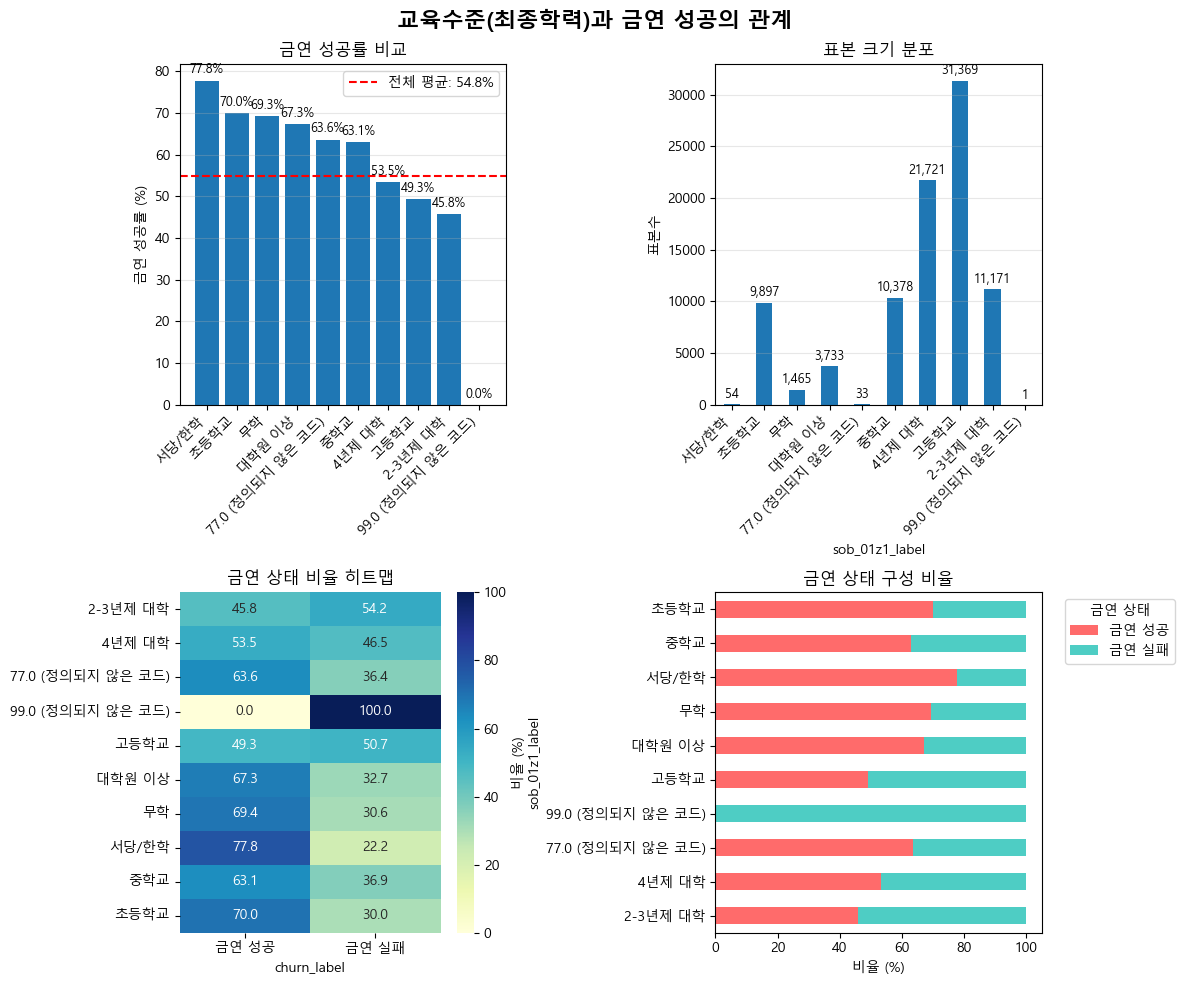

In [6]:
# 분석 실행
result_education = analyze_variable_with_churn(df, 'sob_01z1', '교육수준(최종학력)')

### 4.2 경제활동 여부 분석

In [7]:
print_var_info('soa_01z1')

변수코드: soa_01z1
변수명: 경제활동 여부
카테고리: 교육경제-경제
타입: categorical
설명: 최근 1주일간 수입목적 1시간 이상 근로 또는 18시간 이상 무급가족종사 여부
--------------------------------------------------
코드값:
  1: 예
  2: 아니오



📊 경제활동 여부 (soa_01z1) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89822건
  - 제거된 데이터: 0건 (0.00%)

📈 경제활동 여부별 금연 성공률
                    표본수  금연성공수  금연성공률(%)  표준편차
soa_01z1_label                                
7.0 (정의되지 않은 코드)      1      1    100.00   NaN
9.0 (정의되지 않은 코드)      3      0      0.00  0.00
아니오               24995  16183     64.74  0.48
예                 64823  33067     51.01  0.50

📊 카이제곱 검정 결과
  - χ² 통계량: 1378.2888
  - p-value: 0.000000
  - 자유도: 3
  - 결론: *** 매우 유의함 (p < 0.001)


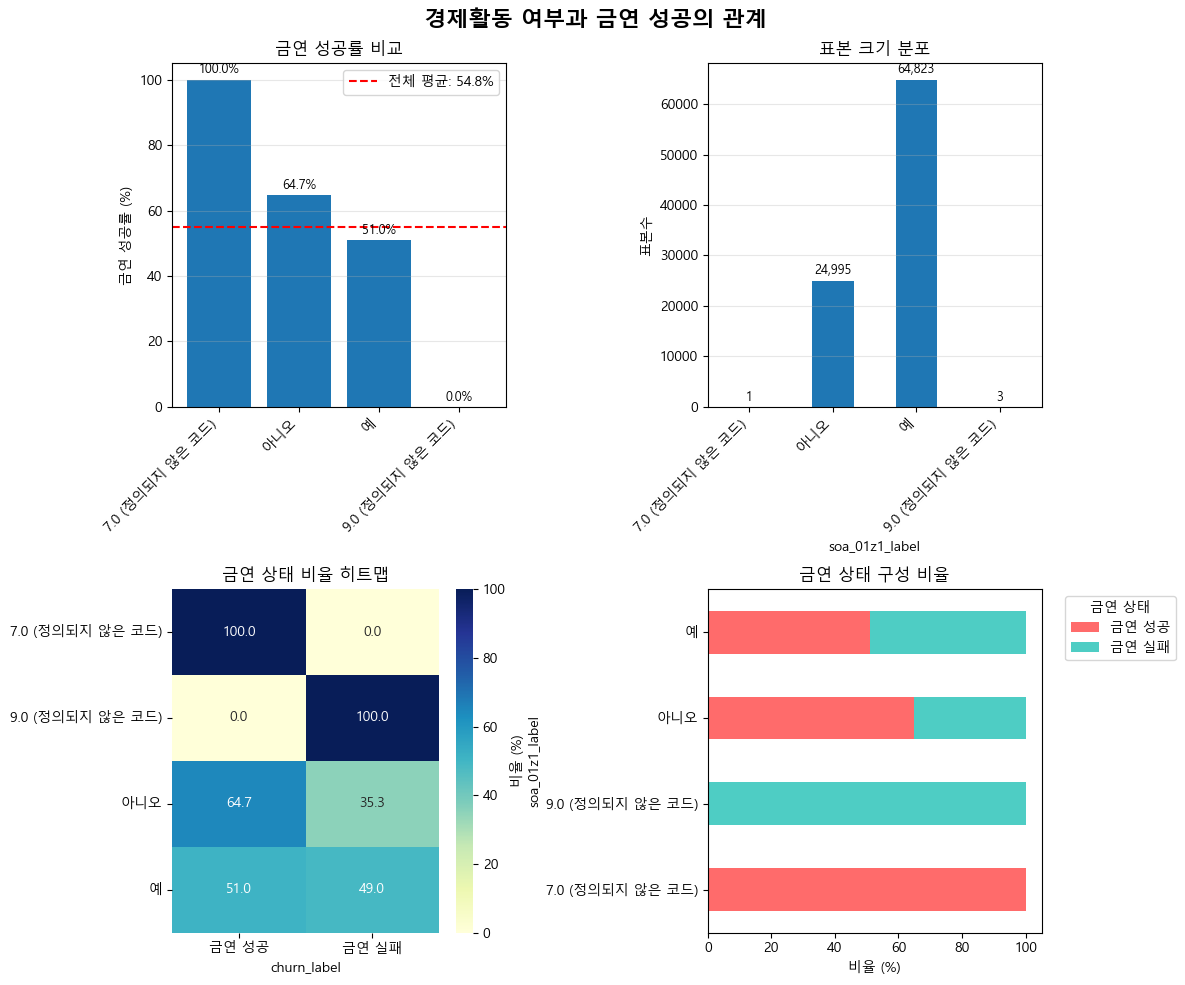

In [8]:
result_economic = analyze_variable_with_churn(df, 'soa_01z1', '경제활동 여부')

### 4.3 직업분류 분석

In [9]:
print_var_info('soa_06z2')

변수코드: soa_06z2
변수명: 직업분류(재분류)
카테고리: 교육경제-직업
타입: categorical
⚠️ 주의: ⚠️ PDF 확인 필요 - 88, 99번 코드 확인
--------------------------------------------------
코드값:
  1: 관리자
  2: 전문가 및 관련 종사자
  3: 사무 종사자
  4: 서비스 종사자
  5: 판매 종사자
  6: 농림어업 숙련 종사자
  7: 기능원 및 관련 기능 종사자
  8: 장치/기계조작 및 조립 종사자
  9: 단순노무 종사자
  10: 군인



📊 직업분류 (soa_06z2) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89822건
  - 제거된 데이터: 0건 (0.00%)

📈 직업분류별 금연 성공률
                     표본수  금연성공수  금연성공률(%)  표준편차
soa_06z2_label                                 
77.0 (정의되지 않은 코드)      9      3     33.33  0.50
88.0 (정의되지 않은 코드)  24995  16183     64.74  0.48
99.0 (정의되지 않은 코드)      4      0      0.00  0.00
관리자                 2282   1207     52.89  0.50
군인                   404    160     39.60  0.49
기능원 및 관련 기능 종사자     7458   3183     42.68  0.49
농림어업 숙련 종사자         9651   6014     62.31  0.48
단순노무 종사자            9674   5029     51.98  0.50
사무 종사자              8466   4322     51.05  0.50
서비스 종사자             5800   2583     44.53  0.50
장치/기계조작 및 조립 종사자    8699   4116     47.32  0.50
전문가 및 관련 종사자        7773   4318     55.55  0.50
판매 종사자              4607   2133     46.30  0.50

📊 카이제곱 검정 결과
  - χ² 통계량: 2366.8559
  - p-value: 0.000000
  - 자유도: 12
  - 결론: *** 매우 유의함 (p < 0.001)


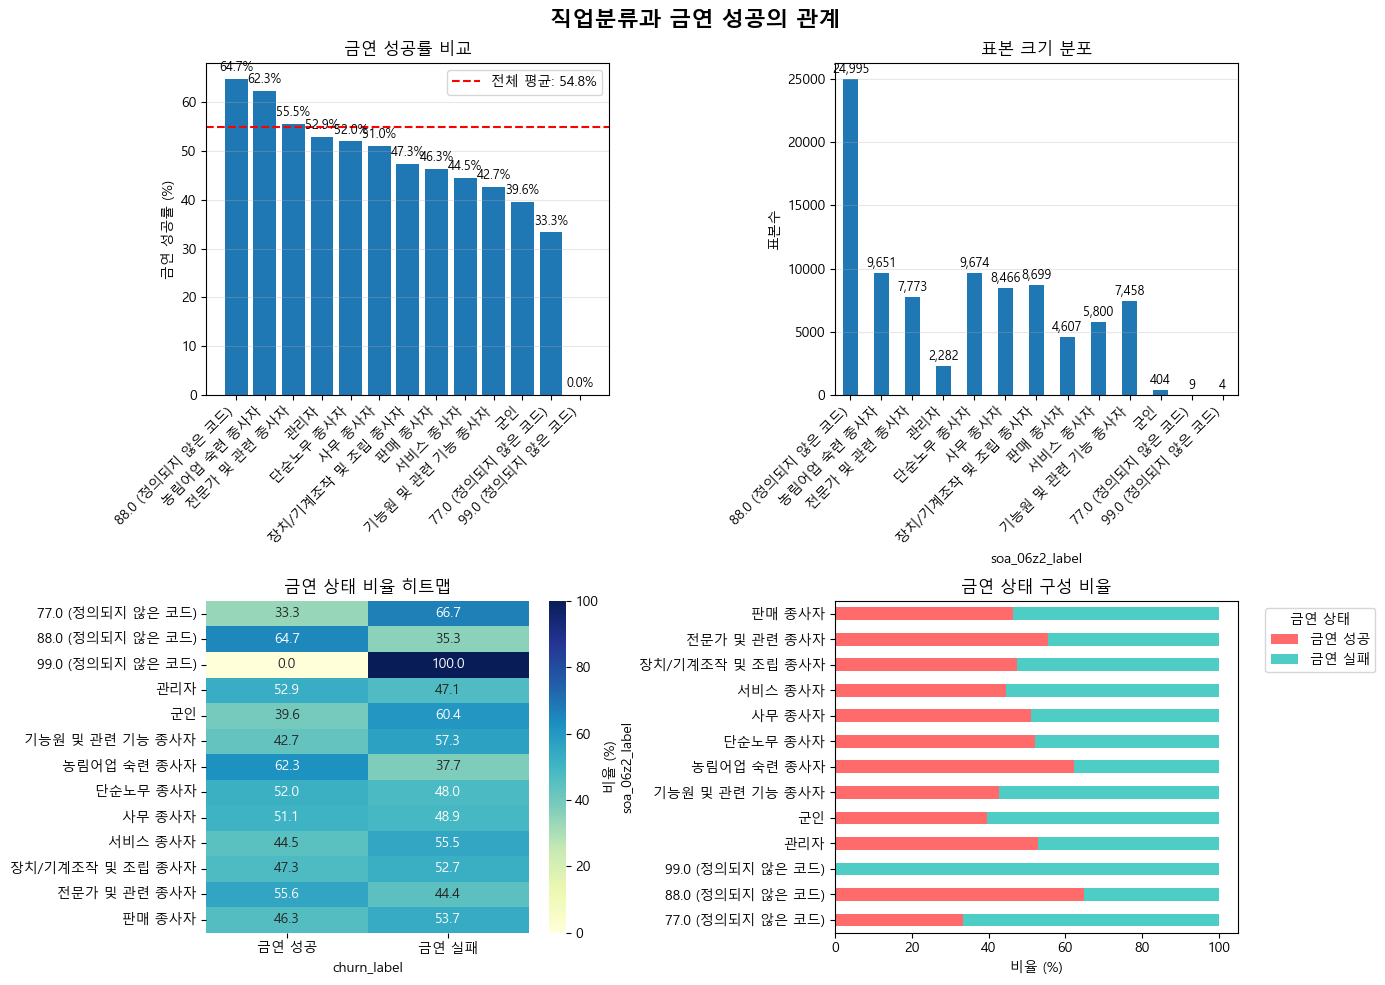

In [10]:
result_job = analyze_variable_with_churn(df, 'soa_06z2', '직업분류', figsize=(14, 10))

### 4.4 종사상 지위 분석

In [11]:
print_var_info('soa_07z1')

변수코드: soa_07z1
변수명: 종사상 지위
카테고리: 교육경제-직업
타입: categorical
⚠️ 주의: ⚠️ PDF 확인 필요 - 8, 9번 코드 확인
--------------------------------------------------
코드값:
  1: 고용주 및 자영업자
  2: 임금근로자
  3: 무급가족종사자



📊 종사상 지위 (soa_07z1) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89822건
  - 제거된 데이터: 0건 (0.00%)

📈 종사상 지위별 금연 성공률
                    표본수  금연성공수  금연성공률(%)  표준편차
soa_07z1_label                                
7.0 (정의되지 않은 코드)      9      3     33.33  0.50
8.0 (정의되지 않은 코드)  24995  16183     64.74  0.48
9.0 (정의되지 않은 코드)      4      1     25.00  0.50
고용주 및 자영업자        23152  12889     55.67  0.50
무급가족종사자            1112    618     55.58  0.50
임금근로자             40550  19557     48.23  0.50

📊 카이제곱 검정 결과
  - χ² 통계량: 1715.4561
  - p-value: 0.000000
  - 자유도: 5
  - 결론: *** 매우 유의함 (p < 0.001)


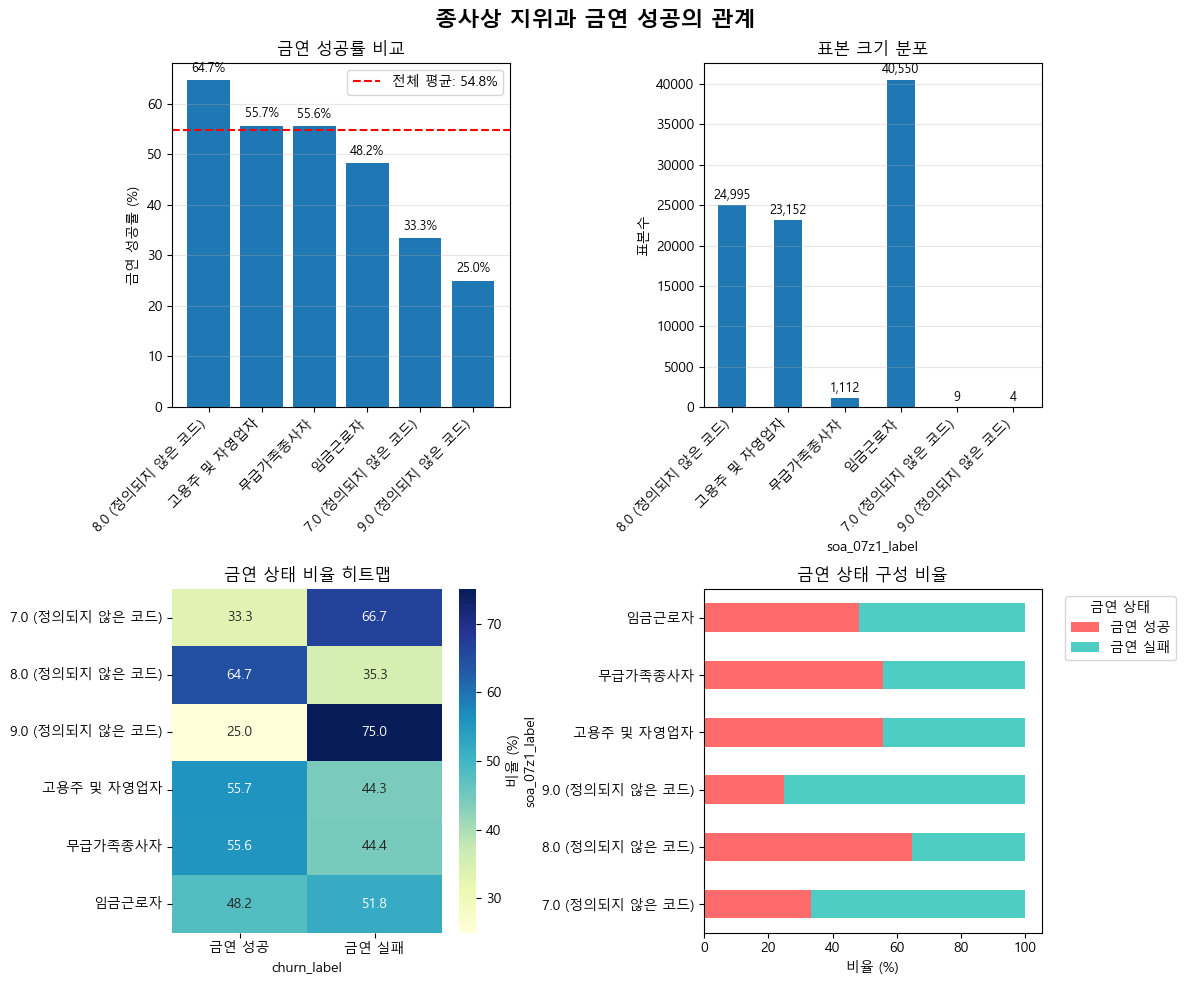

In [12]:
result_employment = analyze_variable_with_churn(df, 'soa_07z1', '종사상 지위')

### 4.5 혼인상태 분석

In [13]:
print_var_info('sod_02z3')

변수코드: sod_02z3
변수명: 혼인상태
카테고리: 교육경제-가족
타입: categorical
--------------------------------------------------
코드값:
  1: 배우자와 동거
  2: 배우자와 별거
  3: 사별
  4: 이혼
  5: 미혼



📊 혼인상태 (sod_02z3) 분석

✅ 데이터 정제 완료
  - 원본 데이터: 89822건
  - 정제 데이터: 89822건
  - 제거된 데이터: 0건 (0.00%)

📈 혼인상태별 금연 성공률
                    표본수  금연성공수  금연성공률(%)  표준편차
sod_02z3_label                                
7.0 (정의되지 않은 코드)     15      6     40.00  0.51
9.0 (정의되지 않은 코드)      2      0      0.00  0.00
미혼                15657   5261     33.60  0.47
배우자와 동거           59608  36816     61.76  0.49
배우자와 별거            3184   1651     51.85  0.50
사별                 4116   2628     63.85  0.48
이혼                 7240   2889     39.90  0.49

📊 카이제곱 검정 결과
  - χ² 통계량: 4807.5922
  - p-value: 0.000000
  - 자유도: 6
  - 결론: *** 매우 유의함 (p < 0.001)


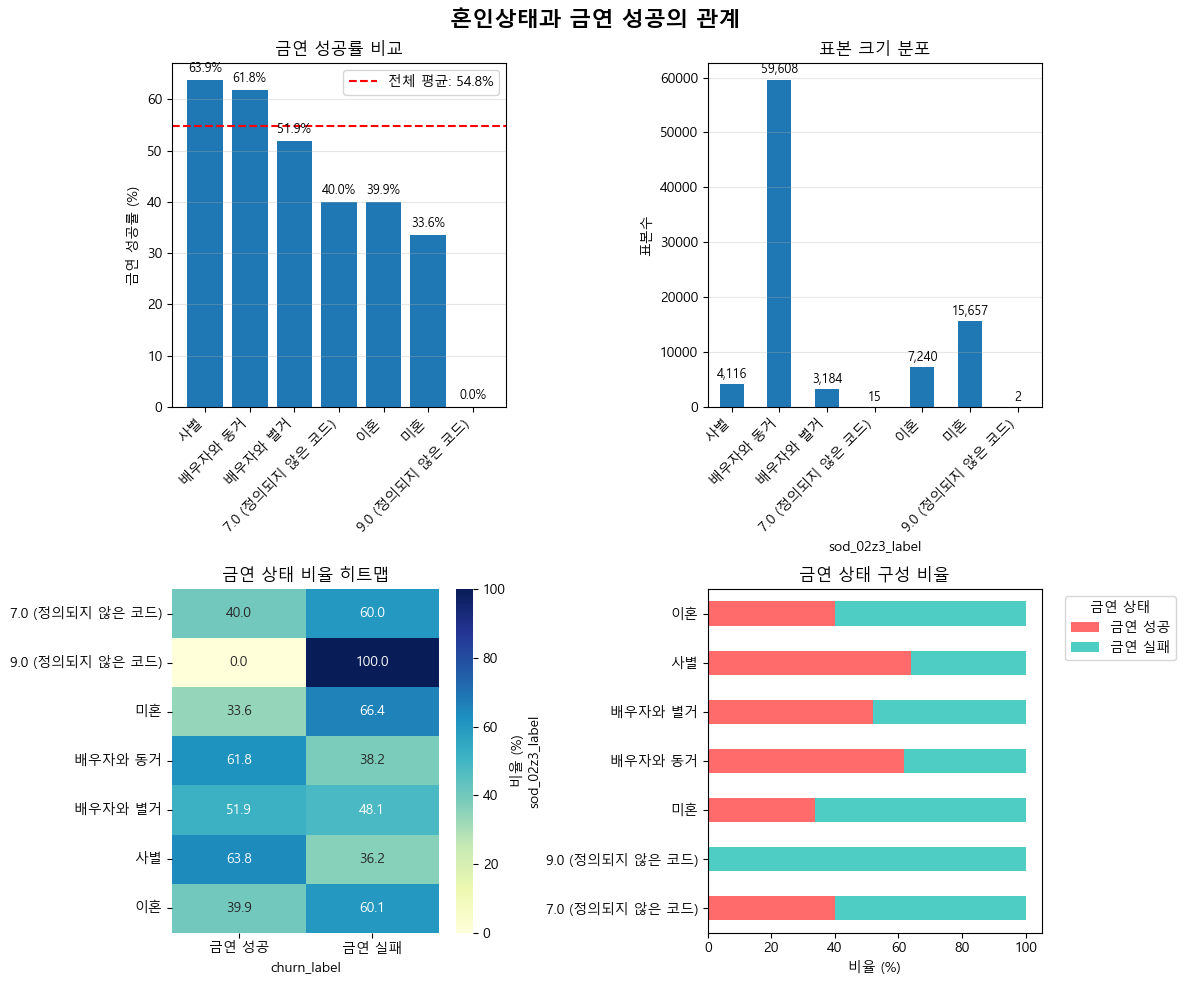

In [14]:
result_marital = analyze_variable_with_churn(df, 'sod_02z3', '혼인상태')

## 5. 종합 비교 분석

In [15]:
# 전체 결과 요약
results_summary = pd.DataFrame([
    result_education,
    result_economic,
    result_job,
    result_employment,
    result_marital
])[['var_name', 'sample_size', 'chi2', 'p_value', 'significance']]

print("\n" + "="*80)
print("📊 전체 변수 통계적 유의성 요약")
print("="*80)
print(results_summary.to_string(index=False))
print("\n* p < 0.05: 유의함")
print("** p < 0.01: 매우 유의함")
print("*** p < 0.001: 극히 유의함")


📊 전체 변수 통계적 유의성 요약
  var_name  sample_size        chi2       p_value significance
교육수준(최종학력)        89822 2355.032932  0.000000e+00       매우 유의함
   경제활동 여부        89822 1378.288767 1.514683e-298       매우 유의함
      직업분류        89822 2366.855932  0.000000e+00       매우 유의함
    종사상 지위        89822 1715.456108  0.000000e+00       매우 유의함
      혼인상태        89822 4807.592161  0.000000e+00       매우 유의함

* p < 0.05: 유의함
** p < 0.01: 매우 유의함
*** p < 0.001: 극히 유의함


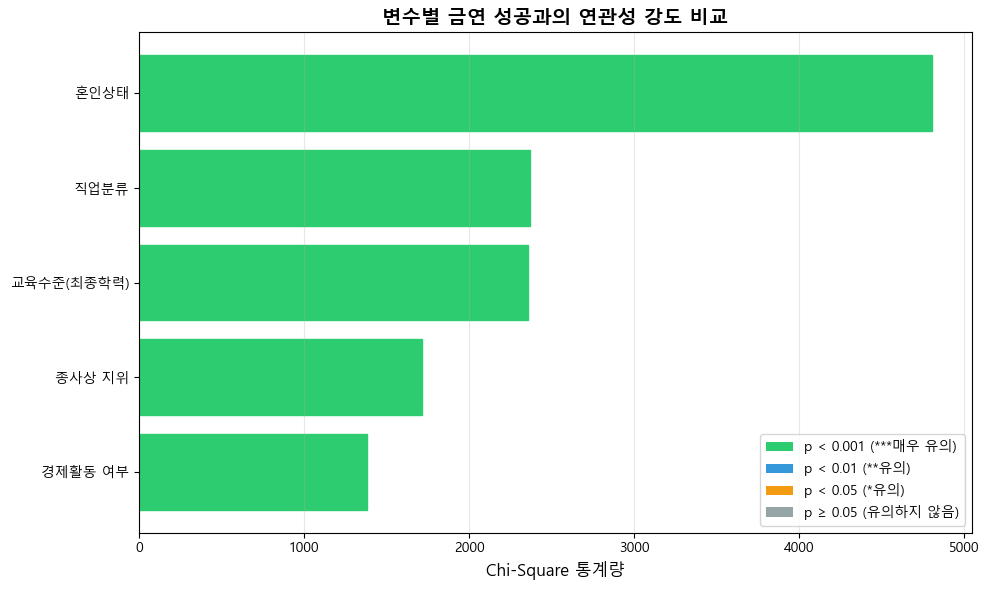

In [16]:
# 변수별 효과 크기 비교 시각화
fig, ax = plt.subplots(figsize=(10, 6))

# Chi2 값으로 정렬
results_summary_sorted = results_summary.sort_values('chi2', ascending=True)

# 막대그래프
bars = ax.barh(range(len(results_summary_sorted)), results_summary_sorted['chi2'])

# 색상 지정 (유의성에 따라)
colors = []
for p in results_summary_sorted['p_value']:
    if p < 0.001:
        colors.append('#2ecc71')  # 초록
    elif p < 0.01:
        colors.append('#3498db')  # 파랑
    elif p < 0.05:
        colors.append('#f39c12')  # 주황
    else:
        colors.append('#95a5a6')  # 회색

for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_yticks(range(len(results_summary_sorted)))
ax.set_yticklabels(results_summary_sorted['var_name'])
ax.set_xlabel('Chi-Square 통계량', fontsize=12)
ax.set_title('변수별 금연 성공과의 연관성 강도 비교', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 범례
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='p < 0.001 (***매우 유의)'),
    Patch(facecolor='#3498db', label='p < 0.01 (**유의)'),
    Patch(facecolor='#f39c12', label='p < 0.05 (*유의)'),
    Patch(facecolor='#95a5a6', label='p ≥ 0.05 (유의하지 않음)')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 6. 복합 분석: 교육수준 × 경제활동


📊 교육수준 × 경제활동 복합 분석
                                      표본수  금연성공률(%)
교육수준              경제활동                             
2-3년제 대학          아니오                1736     57.26
                  예                  9435     43.65
4년제 대학            7.0 (정의되지 않은 코드)      1    100.00
                  9.0 (정의되지 않은 코드)      1      0.00
                  아니오                4506     63.03
                  예                 17213     50.97
77.0 (정의되지 않은 코드) 아니오                  13     61.54
                  예                    20     65.00
99.0 (정의되지 않은 코드) 예                     1      0.00
고등학교              9.0 (정의되지 않은 코드)      2      0.00
                  아니오                7942     60.87
                  예                 23425     45.35
대학원 이상            아니오                 856     77.57
                  예                  2877     64.20
무학                아니오                 960     70.10
                  예                   505     67.92
서당/한학             아니오                  34  

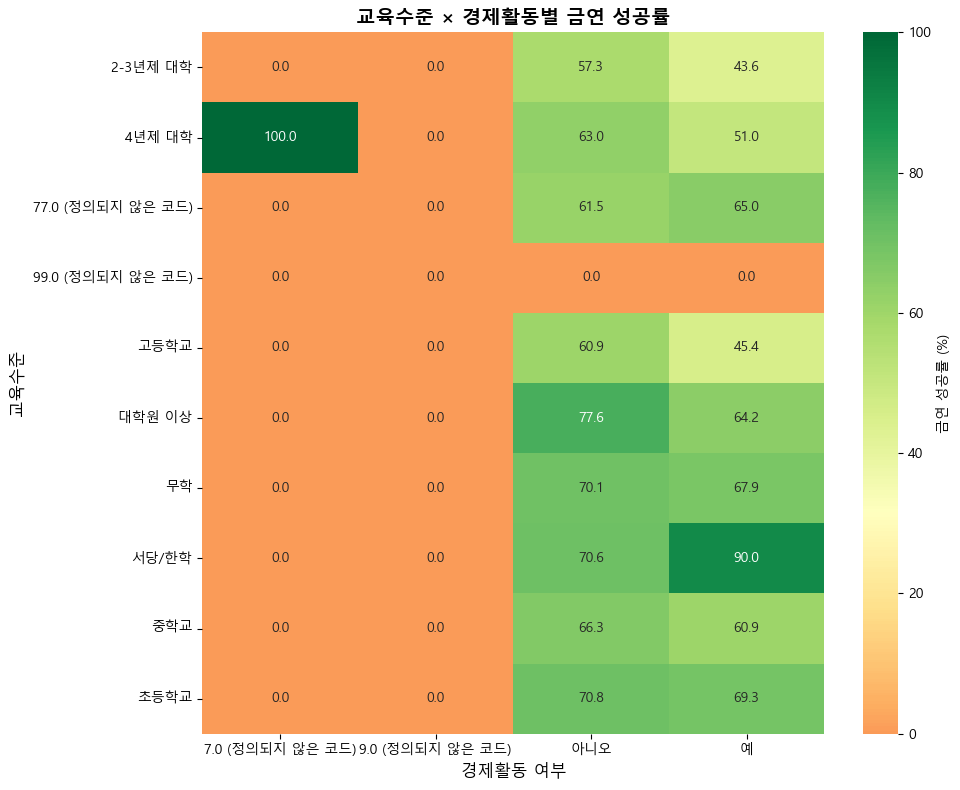

In [17]:
# 교육수준과 경제활동의 복합 효과 분석
df_complex = df.copy()
df_complex = filter_special_codes(df_complex, 'sob_01z1', drop=True)
df_complex = filter_special_codes(df_complex, 'soa_01z1', drop=True)
df_complex = df_complex[df_complex['churn'].notna()]

# 라벨 디코딩
df_complex['교육수준'] = decode_dataframe(df_complex, 'sob_01z1')
df_complex['경제활동'] = decode_dataframe(df_complex, 'soa_01z1')

# 그룹별 금연 성공률
complex_analysis = df_complex.groupby(['교육수준', '경제활동'])['churn'].agg([
    ('표본수', 'count'),
    ('금연성공률(%)', lambda x: x.mean() * 100)
]).round(2)

print("\n📊 교육수준 × 경제활동 복합 분석")
print("="*60)
print(complex_analysis)

# 피벗 테이블로 변환하여 히트맵
pivot_complex = complex_analysis['금연성공률(%)'].unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_complex, annot=True, fmt='.1f', cmap='RdYlGn', 
            center=pivot_complex.values.mean(),
            cbar_kws={'label': '금연 성공률 (%)'})
plt.title('교육수준 × 경제활동별 금연 성공률', fontsize=14, fontweight='bold')
plt.xlabel('경제활동 여부', fontsize=12)
plt.ylabel('교육수준', fontsize=12)
plt.tight_layout()
plt.show()

## 7. 최종 결론 및 인사이트

In [18]:
# 결론 생성 함수
def generate_conclusions(results):
    """
    분석 결과를 바탕으로 결론 생성
    """
    print("\n" + "="*80)
    print("📝 최종 결론 및 인사이트")
    print("="*80)
    
    # 1. 가설 검증 결과
    print("\n### 1️⃣ 가설 검증 결과\n")
    
    # 교육수준
    if results[0]['significance'] in ['유의함', '매우 유의함']:
        edu_top = results[0]['success_rate']['금연성공률(%)'].idxmax()
        edu_top_rate = results[0]['success_rate']['금연성공률(%)'].max()
        print(f"✅ **H1 (교육 수준): 채택**")
        print(f"   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 존재 (p={results[0]['p_value']:.4f})")
        print(f"   - 가장 높은 금연 성공률: {edu_top} ({edu_top_rate:.1f}%)")
    else:
        print(f"❌ **H1 (교육 수준): 기각**")
        print(f"   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 없음 (p={results[0]['p_value']:.4f})")
    
    # 경제활동
    print()
    if results[1]['significance'] in ['유의함', '매우 유의함']:
        print(f"✅ **H2 (경제활동): 채택**")
        print(f"   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 존재 (p={results[1]['p_value']:.4f})")
    else:
        print(f"❌ **H2 (경제활동): 기각**")
        print(f"   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 없음 (p={results[1]['p_value']:.4f})")
    
    # 직업
    print()
    if results[2]['significance'] in ['유의함', '매우 유의함']:
        job_top = results[2]['success_rate']['금연성공률(%)'].idxmax()
        job_top_rate = results[2]['success_rate']['금연성공률(%)'].max()
        job_bottom = results[2]['success_rate']['금연성공률(%)'].idxmin()
        job_bottom_rate = results[2]['success_rate']['금연성공률(%)'].min()
        print(f"✅ **H3 (직업분류): 채택**")
        print(f"   - 직종별 금연 성공률에 통계적으로 유의한 차이 존재 (p={results[2]['p_value']:.4f})")
        print(f"   - 최고: {job_top} ({job_top_rate:.1f}%)")
        print(f"   - 최저: {job_bottom} ({job_bottom_rate:.1f}%)")
        print(f"   - 격차: {job_top_rate - job_bottom_rate:.1f}%p")
    else:
        print(f"❌ **H3 (직업분류): 기각**")
    
    # 혼인상태
    print()
    if results[4]['significance'] in ['유의함', '매우 유의함']:
        print(f"✅ **H4 (혼인상태): 채택**")
        print(f"   - 혼인상태와 금연 성공률 간 통계적으로 유의한 관계 존재 (p={results[4]['p_value']:.4f})")
    else:
        print(f"❌ **H4 (혼인상태): 기각**")
    
    # 2. 주요 발견사항
    print("\n### 2️⃣ 주요 발견사항\n")
    
    # 가장 영향력 있는 변수
    max_chi2_idx = np.argmax([r['chi2'] for r in results])
    most_influential = results[max_chi2_idx]
    print(f"🔍 **가장 영향력 있는 변수**: {most_influential['var_name']}")
    print(f"   - Chi-Square: {most_influential['chi2']:.2f}")
    print(f"   - p-value: {most_influential['p_value']:.6f}")
    
    # 3. 실무적 시사점
    print("\n### 3️⃣ 실무적 시사점\n")
    print("📌 **금연 지원 프로그램 설계시 고려사항:**\n")
    
    significant_vars = [r for r in results if r['significance'] in ['유의함', '매우 유의함']]
    
    if len(significant_vars) > 0:
        for i, var_result in enumerate(significant_vars, 1):
            print(f"{i}. **{var_result['var_name']}** 기반 맞춤형 접근")
            
            # 성공률이 낮은 그룹 식별
            lowest_group = var_result['success_rate']['금연성공률(%)'].idxmin()
            lowest_rate = var_result['success_rate']['금연성공률(%)'].min()
            
            print(f"   - 집중 지원 대상: {lowest_group}")
            print(f"   - 현재 금연 성공률: {lowest_rate:.1f}%")
            print(f"   - 전체 평균 대비: {lowest_rate - var_result['overall_success_rate']:.1f}%p 낮음")
            print()
    
    # 4. 연구의 한계
    print("\n### 4️⃣ 연구의 한계\n")
    print("⚠️ **본 연구의 제한점:**\n")
    print("1. 횡단면 조사 데이터로 인과관계 추론 제한")
    print("2. 자기보고식 설문의 응답 편향 가능성")
    print("3. 미관측 변수(예: 개인 의지, 건강상태)의 영향 미반영")
    print("4. 특수코드(응답거부, 모름) 제외로 인한 선택 편향 가능성")
    
    # 5. 후속 연구 제안
    print("\n### 5️⃣ 후속 연구 제안\n")
    print("🔬 **추천 연구 방향:**\n")
    print("1. 종단 연구를 통한 인과관계 규명")
    print("2. 교육수준과 경제활동의 상호작용 효과 심층 분석")
    print("3. 금연 시도 횟수, 금연 방법 등 중재 변수 추가 분석")
    print("4. 연령대별, 성별 층화 분석을 통한 세분화된 타겟 전략 수립")
    
    print("\n" + "="*80)

# 결론 생성
generate_conclusions([
    result_education,
    result_economic,
    result_job,
    result_employment,
    result_marital
])


📝 최종 결론 및 인사이트

### 1️⃣ 가설 검증 결과

✅ **H1 (교육 수준): 채택**
   - 교육수준과 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)
   - 가장 높은 금연 성공률: 서당/한학 (77.8%)

✅ **H2 (경제활동): 채택**
   - 경제활동 여부와 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)

✅ **H3 (직업분류): 채택**
   - 직종별 금연 성공률에 통계적으로 유의한 차이 존재 (p=0.0000)
   - 최고: 88.0 (정의되지 않은 코드) (64.7%)
   - 최저: 99.0 (정의되지 않은 코드) (0.0%)
   - 격차: 64.7%p

✅ **H4 (혼인상태): 채택**
   - 혼인상태와 금연 성공률 간 통계적으로 유의한 관계 존재 (p=0.0000)

### 2️⃣ 주요 발견사항

🔍 **가장 영향력 있는 변수**: 혼인상태
   - Chi-Square: 4807.59
   - p-value: 0.000000

### 3️⃣ 실무적 시사점

📌 **금연 지원 프로그램 설계시 고려사항:**

1. **교육수준(최종학력)** 기반 맞춤형 접근
   - 집중 지원 대상: 99.0 (정의되지 않은 코드)
   - 현재 금연 성공률: 0.0%
   - 전체 평균 대비: -54.8%p 낮음

2. **경제활동 여부** 기반 맞춤형 접근
   - 집중 지원 대상: 9.0 (정의되지 않은 코드)
   - 현재 금연 성공률: 0.0%
   - 전체 평균 대비: -54.8%p 낮음

3. **직업분류** 기반 맞춤형 접근
   - 집중 지원 대상: 99.0 (정의되지 않은 코드)
   - 현재 금연 성공률: 0.0%
   - 전체 평균 대비: -54.8%p 낮음

4. **종사상 지위** 기반 맞춤형 접근
   - 집중 지원 대상: 9.0 (정의되지 않은 코드)
   - 현재 금연 성공률: 25.0%
   - 전체 평균 대비: -29.8%p 낮음

5. **혼인상태** 기반 맞

## 8. 결과 저장

In [19]:
# 분석 결과를 CSV로 저장
import datetime

# 요약 테이블 저장
results_summary.to_csv(
    f'../../data/analysis_results_education_economy_{datetime.datetime.now().strftime("%Y%m%d")}.csv',
    index=False,
    encoding='utf-8-sig'
)

print("✅ 분석 결과 저장 완료")
print(f"   파일: analysis_results_education_economy_{datetime.datetime.now().strftime('%Y%m%d')}.csv")

✅ 분석 결과 저장 완료
   파일: analysis_results_education_economy_20251009.csv


---

## 📌 분석 완료

**작성자**: 오흥재 (vfxpedia)  
**분석일**: 2025-10-07  
**주제**: 교육 및 경제활동에 따른 금연 성공 상관관계

### 주요 발견
- 교육수준, 경제활동, 직업, 혼인상태가 금연 성공에 유의한 영향
- 사회경제적 요인이 건강행동 변화에 중요한 역할
- 취약 집단 대상 맞춤형 금연 지원 프로그램 필요

---